In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [2]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

# Reading the data

In [16]:
Wgamma_fidcross  = 563.6909804820438
Wjets_fidcross   = 606.8765059826087
ttgamma_fidcross = 15.785724594666668
B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross
B_fidcross_tot

1701.044633464176

In [17]:
B_expected = (2892.9255431614697 + 56369.098048204374 + 60687.65059826087)

In [24]:
sample = 150000 # Number of signal and background events to plot their distributions

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)

51550
97058
1392


In [25]:
##############
# input data #
##############

# photon -> (pT, eta, phi) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, num_jets)  HT: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_2.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_2.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_2.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_2.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_2.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_2.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_2.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_2.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_2.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_2.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_2.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_2.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_2.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_2.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_2.dat', delimiter=' ')


photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample]])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample]]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample]])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample]])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample]])


In [26]:
bkg_flag = np.zeros(2*len(photon_SM))

bkg_flag[:Wgamma_sample] = 1
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2
bkg_flag[(Wgamma_sample + Wjets_sample):len(photon_SM)] = 3

In [27]:
photon_Wjets.shape

(98061, 3)

In [28]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_2.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_2.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_2.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_2.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_2.dat', delimiter=' ') )

In [29]:
print('SM', jet_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], jet_NP[i].shape)

SM (150000, 3)
BP1 (238160, 3)
BP2 (246196, 3)
BP3 (242249, 3)
BP4 (301575, 3)
BP5 (266047, 3)
BP6 (203155, 3)
BP7 (315960, 3)
BP8 (280065, 3)
BP9 (225958, 3)
BP10 (326687, 3)
BP11 (292051, 3)
BP12 (244271, 3)
BP13 (334782, 3)
BP14 (301215, 3)
BP15 (258277, 3)


In [30]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([836673,1e6,1.4e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6])
signal_cut_ev       = np.asarray([238160,246196,24249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.01975705 4.59249772 0.63746286 1.11014281 2.35046139 3.34036999
 0.66077347 1.29094281 1.79376306 0.39998985 0.73619851 1.02039447
 0.22861593 0.4113874  0.57320964]
Events expected:  [201.97570473 459.24977152  63.74628649 111.01428112 235.04613937
 334.03699928  66.07734672 129.09428136 179.37630638  39.99898458
  73.61985102 102.03944697  22.86159322  41.13873984  57.32096427]


In [31]:
# other variables, individual channels:

HT_main_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0],np.sqrt(HT_main_Wgamma) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

HT_main_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(HT_main_Wjets) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )



HT_main_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(HT_main_ttgamma) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )



# other variables

HT_main_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(HT_main_SM) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [32]:
# other variables NEW PHYSICS
HT_main_NP = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    HT_main_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(HT_main_NP[i]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [33]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(150000, 3)
(238160, 3)


# Plots

In [34]:
cmap = cm.get_cmap('viridis', len(photon_NP))

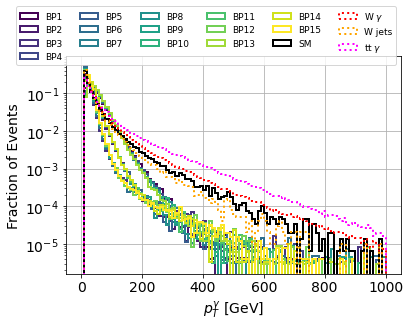

In [35]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,0])/len(photon_NP[i][:,0])
    plt.hist(photon_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,0])/len(photon_SM[:,0])
plt.hist(photon_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,0])/len(photon_Wgamma[:,0])
plt.hist(photon_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,0])/len(photon_Wjets[:,0])
plt.hist(photon_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,0])/len(photon_ttgamma[:,0])
plt.hist(photon_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()
plt.xlabel(r"$p_T^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingPhoton_dist.png', bbox_inches='tight')

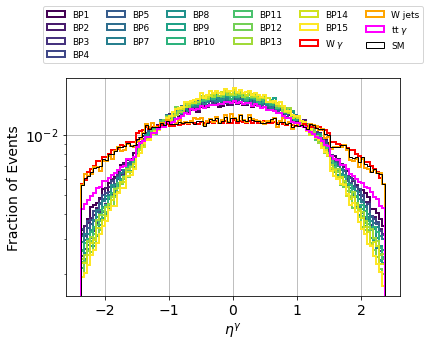

In [36]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,1])/len(photon_NP[i][:,1])
    plt.hist(photon_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_Wgamma[:,1])/len(photon_Wgamma[:,1])
plt.hist(photon_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,1])/len(photon_Wjets[:,1])
plt.hist(photon_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,1])/len(photon_ttgamma[:,1])
plt.hist(photon_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='solid', edgecolor='magenta', histtype='step', label="tt $\gamma$")
weights = np.ones_like(photon_SM[:,1])/len(photon_SM[:,1])
plt.hist(photon_SM[:,1], weights=weights, bins=100, lw=1, edgecolor='black', histtype='step', label="SM", zorder=2)

plt.grid()  
plt.xlabel(r"$\eta^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingPhoton_dist.png', bbox_inches='tight')

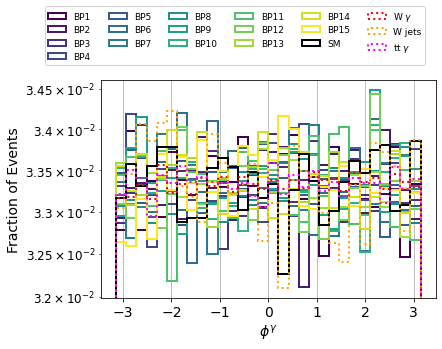

In [37]:
for i in range(len(photon_NP)):
    weights = np.ones_like(photon_NP[i][:,2])/len(photon_NP[i][:,2])
    plt.hist(photon_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(photon_SM[:,2])/len(photon_SM[:,2])
plt.hist(photon_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(photon_Wgamma[:,2])/len(photon_Wgamma[:,2])
plt.hist(photon_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(photon_Wjets[:,2])/len(photon_Wjets[:,2])
plt.hist(photon_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(photon_ttgamma[:,2])/len(photon_ttgamma[:,2])
plt.hist(photon_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{\gamma}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.4, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingPhoton_dist.png', bbox_inches='tight')

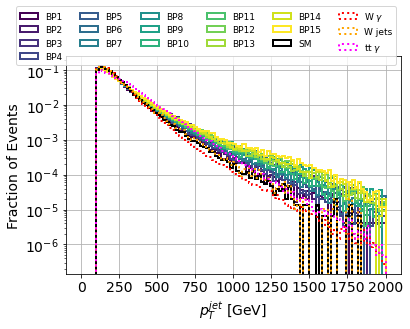

In [38]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,0])/len(jet_NP[i][:,0])
    plt.hist(jet_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,0])/len(jet_SM[:,0])
plt.hist(jet_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,0])/len(jet_Wgamma[:,0])
plt.hist(jet_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,0])/len(jet_Wjets[:,0])
plt.hist(jet_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,0])/len(jet_ttgamma[:,0])
plt.hist(jet_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingJet_dist.png', bbox_inches='tight')

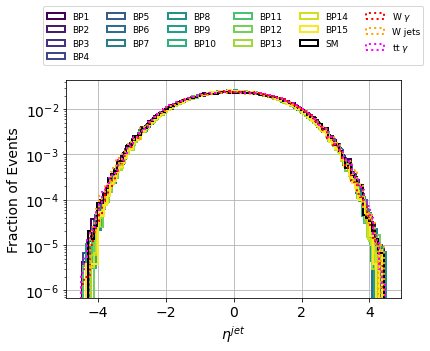

In [39]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,1])/len(jet_NP[i][:,1])
    plt.hist(jet_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,1])/len(jet_SM[:,1])
plt.hist(jet_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,1])/len(jet_Wgamma[:,1])
plt.hist(jet_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,1])/len(jet_Wjets[:,1])
plt.hist(jet_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,1])/len(jet_ttgamma[:,1])
plt.hist(jet_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingJet_dist.png', bbox_inches='tight')

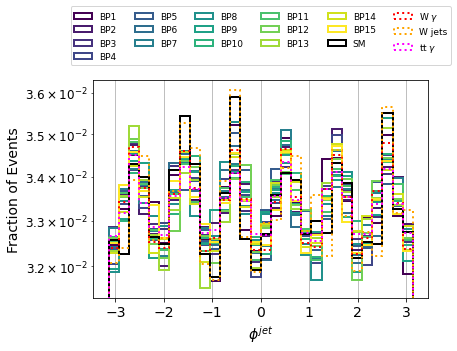

In [40]:
for i in range(len(photon_NP)):
    weights = np.ones_like(jet_NP[i][:,2])/len(jet_NP[i][:,2])
    plt.hist(jet_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(jet_SM[:,2])/len(jet_SM[:,2])
plt.hist(jet_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(jet_Wgamma[:,2])/len(jet_Wgamma[:,2])
plt.hist(jet_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(jet_Wjets[:,2])/len(jet_Wjets[:,2])
plt.hist(jet_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(jet_ttgamma[:,2])/len(jet_ttgamma[:,2])
plt.hist(jet_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{jet}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingJet_dist.png', bbox_inches='tight')

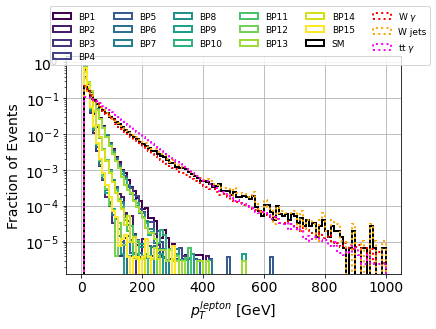

In [41]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,0])/len(lepton_NP[i][:,0])
    plt.hist(lepton_NP[i][:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,0])/len(lepton_SM[:,0])
plt.hist(lepton_SM[:,0], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,0])/len(lepton_Wgamma[:,0])
plt.hist(lepton_Wgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,0])/len(lepton_Wjets[:,0])
plt.hist(lepton_Wjets[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,0])/len(lepton_ttgamma[:,0])
plt.hist(lepton_ttgamma[:,0], weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/pt_leadingLepton_dist.png', bbox_inches='tight')

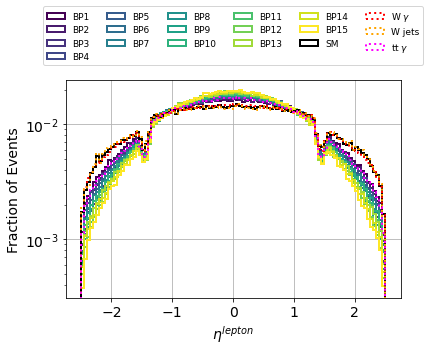

In [42]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,1])/len(lepton_NP[i][:,1])
    plt.hist(lepton_NP[i][:,1], weights=weights, bins=100, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,1])/len(lepton_SM[:,1])
plt.hist(lepton_SM[:,1], weights=weights, bins=100, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,1])/len(lepton_Wgamma[:,1])
plt.hist(lepton_Wgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,1])/len(lepton_Wjets[:,1])
plt.hist(lepton_Wjets[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,1])/len(lepton_ttgamma[:,1])
plt.hist(lepton_ttgamma[:,1], weights=weights, bins=100, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\eta^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/pseudoRapidity_leadingLepton_dist.png', bbox_inches='tight')

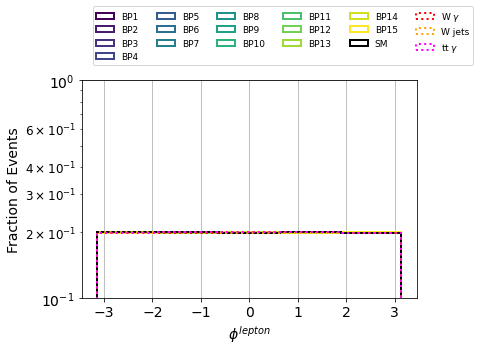

In [43]:
for i in range(len(photon_NP)):
    weights = np.ones_like(lepton_NP[i][:,2])/len(lepton_NP[i][:,2])
    plt.hist(lepton_NP[i][:,2], weights=weights, bins=5, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(lepton_SM[:,2])/len(lepton_SM[:,2])
plt.hist(lepton_SM[:,2], weights=weights, bins=5, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(lepton_Wgamma[:,2])/len(lepton_Wgamma[:,2])
plt.hist(lepton_Wgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(lepton_Wjets[:,2])/len(lepton_Wjets[:,2])
plt.hist(lepton_Wjets[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(lepton_ttgamma[:,2])/len(lepton_ttgamma[:,2])
plt.hist(lepton_ttgamma[:,2], weights=weights, bins=5, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{lepton}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.1,1)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.6, 1.05), ncol = 6)
plt.savefig('../graph/phi_leadingLepton_dist.png', bbox_inches='tight')

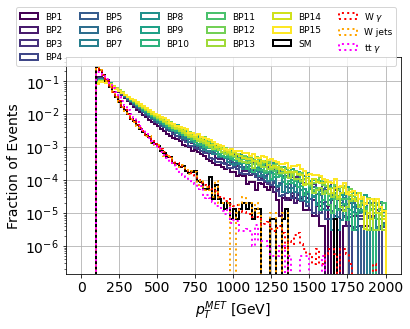

In [44]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,0])/len(MET_NP[i][:,0])
    plt.hist(MET_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,0])/len(MET_SM[:,0])
plt.hist(MET_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,0])/len(MET_Wgamma[:,0])
plt.hist(MET_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,0])/len(MET_Wjets[:,0])
plt.hist(MET_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,0])/len(MET_ttgamma[:,0])
plt.hist(MET_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$p_T^{MET}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/pt_MET_dist.png', bbox_inches='tight')

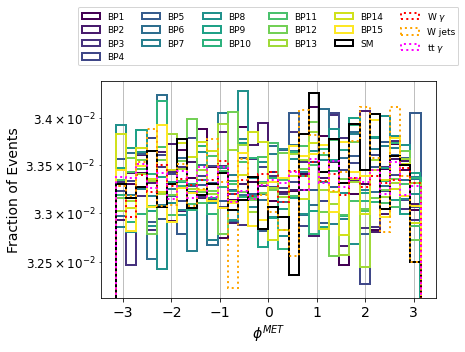

In [45]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_NP[i][:,2])/len(MET_NP[i][:,2])
    plt.hist(MET_NP[i][:,2], weights=weights, bins=30, lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)

weights = np.ones_like(MET_SM[:,2])/len(MET_SM[:,2])
plt.hist(MET_SM[:,2], weights=weights, bins=30, lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_Wgamma[:,2])/len(MET_Wgamma[:,2])
plt.hist(MET_Wgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_Wjets[:,2])/len(MET_Wjets[:,2])
plt.hist(MET_Wjets[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_ttgamma[:,2])/len(MET_ttgamma[:,2])
plt.hist(MET_ttgamma[:,2], weights=weights, bins=30, lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$\phi^{MET}$",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/phi_MET_dist.png', bbox_inches='tight')

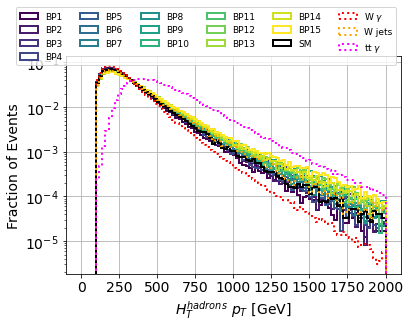

In [46]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,0])/len(hadinfo_NP[i][:,0])
    plt.hist(hadinfo_NP[i][:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,0])/len(hadinfo_SM[:,0])
plt.hist(hadinfo_SM[:,0], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,0])/len(hadinfo_Wgamma[:,0])
plt.hist(hadinfo_Wgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,0])/len(hadinfo_Wjets[:,0])
plt.hist(hadinfo_Wjets[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,0])/len(hadinfo_ttgamma[:,0])
plt.hist(hadinfo_ttgamma[:,0], weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{hadrons}$ $p_T$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/HadInfo_dist.png', bbox_inches='tight')

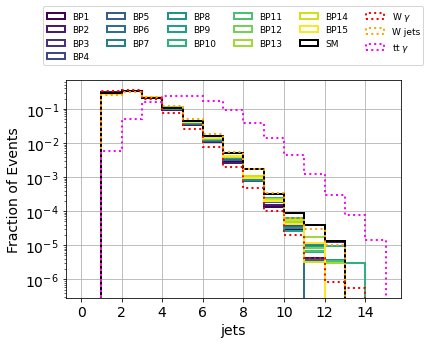

In [47]:
for i in range(len(photon_NP)):
    weights = np.ones_like(hadinfo_NP[i][:,1])/len(hadinfo_NP[i][:,1])
    plt.hist(hadinfo_NP[i][:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(hadinfo_SM[:,1])/len(hadinfo_SM[:,1])
plt.hist(hadinfo_SM[:,1], weights=weights, bins=15, range=[0,15], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(hadinfo_Wgamma[:,1])/len(hadinfo_Wgamma[:,1])
plt.hist(hadinfo_Wgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(hadinfo_Wjets[:,1])/len(hadinfo_Wjets[:,1])
plt.hist(hadinfo_Wjets[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(hadinfo_ttgamma[:,1])/len(hadinfo_ttgamma[:,1])
plt.hist(hadinfo_ttgamma[:,1], weights=weights, bins=15, range=[0,15], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"jets",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='lower center',fontsize=9,bbox_to_anchor=(0.5, 1.05), ncol = 6)
plt.savefig('../graph/jets_dist.png', bbox_inches='tight')

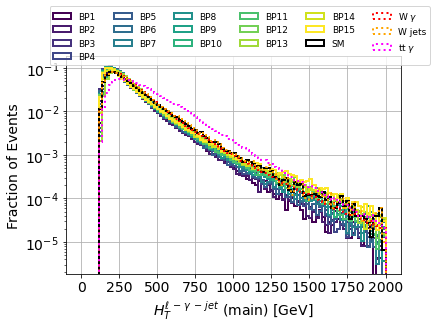

In [48]:
for i in range(len(photon_NP)):
    weights = np.ones_like(HT_main_NP[i])/len(HT_main_NP[i])
    plt.hist(HT_main_NP[i], weights=weights, bins=100, range=[0,2000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(HT_main_SM)/len(HT_main_SM)
plt.hist(HT_main_SM, weights=weights, bins=100, range=[0,2000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(HT_main_Wgamma)/len(HT_main_Wgamma)
plt.hist(HT_main_Wgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(HT_main_Wjets)/len(HT_main_Wjets)
plt.hist(HT_main_Wjets, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(HT_main_ttgamma)/len(HT_main_ttgamma)
plt.hist(HT_main_ttgamma, weights=weights, bins=100, range=[0,2000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$H_T^{\ell \,-\, \gamma \,-\, jet}$ (main) [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/Ht_dist.png', bbox_inches='tight')

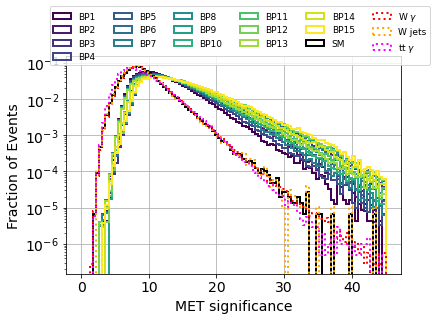

In [49]:
for i in range(len(photon_NP)):
    weights = np.ones_like(MET_sig_NP[i])/len(MET_sig_NP[i])
    plt.hist(MET_sig_NP[i], weights=weights, bins=100, range=[0,45], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(MET_sig_SM)/len(MET_sig_SM)
plt.hist(MET_sig_SM, weights=weights, bins=100, range=[0,45], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(MET_sig_Wgamma)/len(MET_sig_Wgamma)
plt.hist(MET_sig_Wgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(MET_sig_Wjets)/len(MET_sig_Wjets)
plt.hist(MET_sig_Wjets, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(MET_sig_ttgamma)/len(MET_sig_ttgamma)
plt.hist(MET_sig_ttgamma, weights=weights, bins=100, range=[0,45], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"MET significance",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/MET_significance_dist.png', bbox_inches='tight')

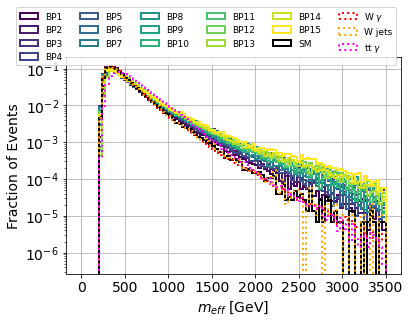

In [50]:
for i in range(len(photon_NP)):
    weights = np.ones_like(m_eff_NP[i])/len(m_eff_NP[i])
    plt.hist(m_eff_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(m_eff_SM)/len(m_eff_SM)
plt.hist(m_eff_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(m_eff_Wgamma)/len(m_eff_Wgamma)
plt.hist(m_eff_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(m_eff_Wjets)/len(m_eff_Wjets)
plt.hist(m_eff_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(m_eff_ttgamma)/len(m_eff_ttgamma)
plt.hist(m_eff_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{eff}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1., 1.25), ncol = 6)
plt.savefig('../graph/Meff_dist.png', bbox_inches='tight')

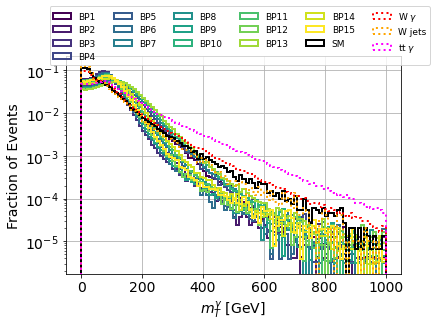

In [51]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_photon_NP[i])/len(mT_photon_NP[i])
    plt.hist(mT_photon_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_photon_SM)/len(mT_photon_SM)
plt.hist(mT_photon_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_photon_Wgamma)/len(mT_photon_Wgamma)
plt.hist(mT_photon_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_photon_Wjets)/len(mT_photon_Wjets)
plt.hist(mT_photon_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_photon_ttgamma)/len(mT_photon_ttgamma)
plt.hist(mT_photon_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{\gamma}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_photon_dist.png', bbox_inches='tight')

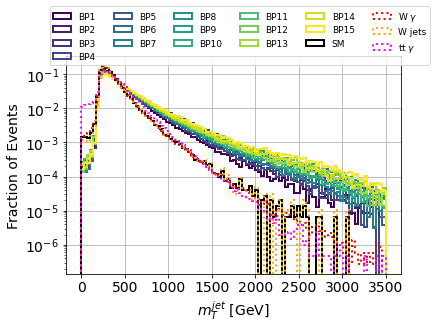

In [52]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_jet_NP[i])/len(mT_jet_NP[i])
    plt.hist(mT_jet_NP[i], weights=weights, bins=100, range=[0,3500], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_jet_SM)/len(mT_jet_SM)
plt.hist(mT_jet_SM, weights=weights, bins=100, range=[0,3500], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_jet_Wgamma)/len(mT_jet_Wgamma)
plt.hist(mT_jet_Wgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_jet_Wjets)/len(mT_jet_Wjets)
plt.hist(mT_jet_Wjets, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_jet_ttgamma)/len(mT_jet_ttgamma)
plt.hist(mT_jet_ttgamma, weights=weights, bins=100, range=[0,3500], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{jet}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Jet_dist.png', bbox_inches='tight')

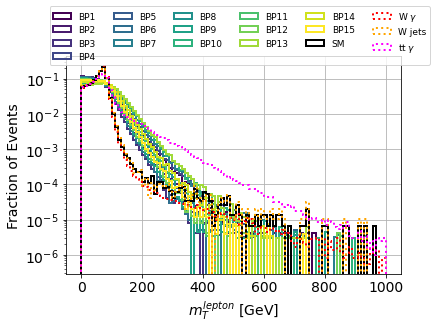

In [53]:
for i in range(len(photon_NP)):
    weights = np.ones_like(mT_lepton_NP[i])/len(mT_lepton_NP[i])
    plt.hist(mT_lepton_NP[i], weights=weights, bins=100, range=[0,1000], lw=2, edgecolor=cmap(i), histtype='step', label=name[i], zorder=2)
    
weights = np.ones_like(mT_lepton_SM)/len(mT_lepton_SM)
plt.hist(mT_lepton_SM, weights=weights, bins=100, range=[0,1000], lw=2, edgecolor='black', histtype='step', label="SM", zorder=2)
weights = np.ones_like(mT_lepton_Wgamma)/len(mT_lepton_Wgamma)
plt.hist(mT_lepton_Wgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='red', histtype='step', label=r"W $\gamma$")
weights = np.ones_like(mT_lepton_Wjets)/len(mT_lepton_Wjets)
plt.hist(mT_lepton_Wjets, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='orange', histtype='step', label="W jets")
weights = np.ones_like(mT_lepton_ttgamma)/len(mT_lepton_ttgamma)
plt.hist(mT_lepton_ttgamma, weights=weights, bins=100, range=[0,1000], lw=2,linestyle='dotted', edgecolor='magenta', histtype='step', label="tt $\gamma$")

plt.grid()  
plt.xlabel(r"$m_{T}^{lepton}$ [GeV]",fontsize=14)
plt.ylabel("Fraction of Events",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.legend(loc='upper right',fontsize=9,bbox_to_anchor=(1.1, 1.25), ncol = 6)
plt.savefig('../graph/mt_Lepton_dist.png', bbox_inches='tight')

## Correlation Plots

In [149]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 1
nobs = 150_000

df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ (had) [GeV]', 'num_jets',
       '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])

df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

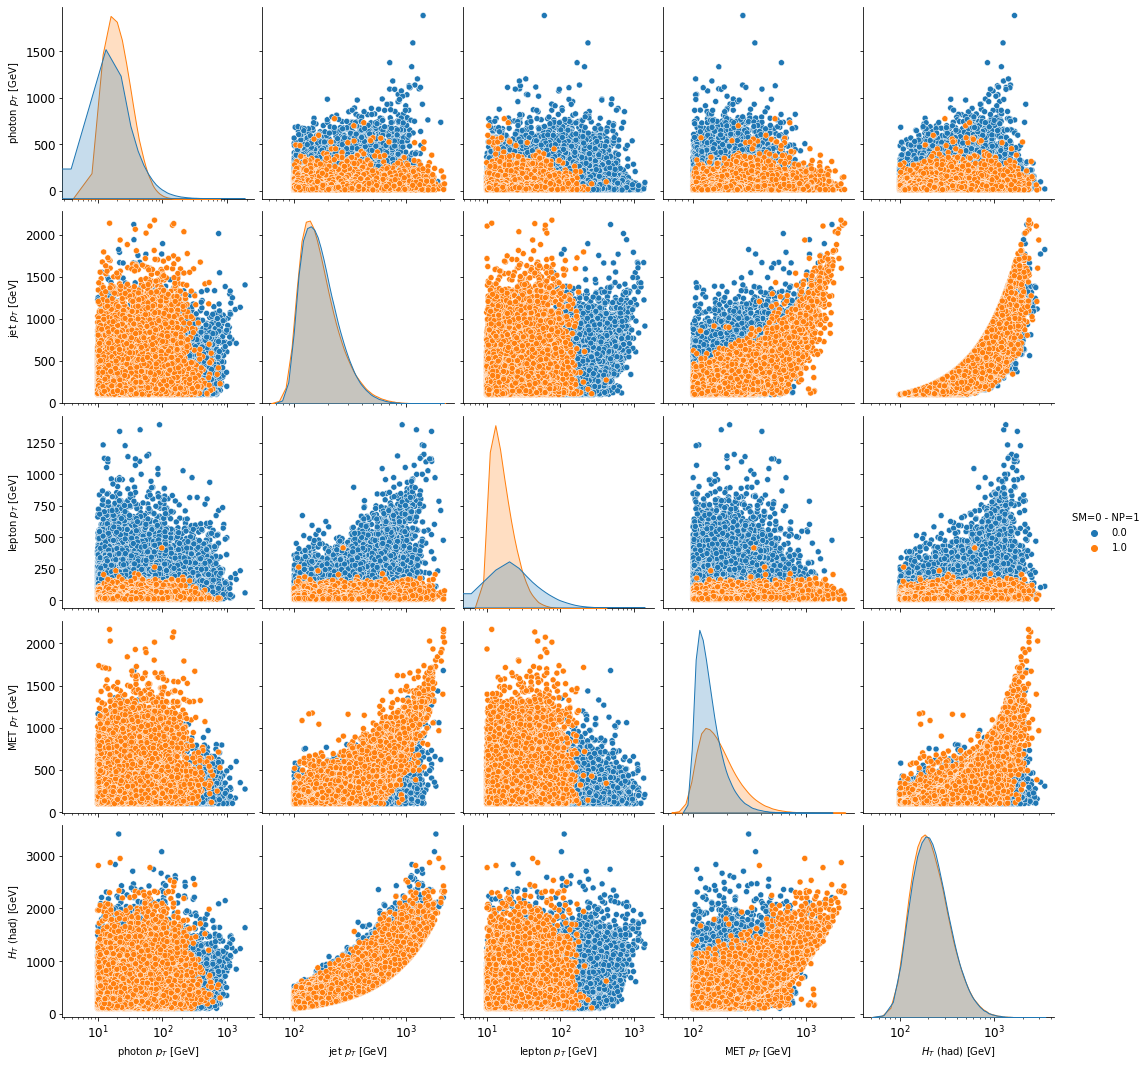

In [89]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[11]])

log_columns = [lst[0],lst[3],lst[6],lst[9],lst[11]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

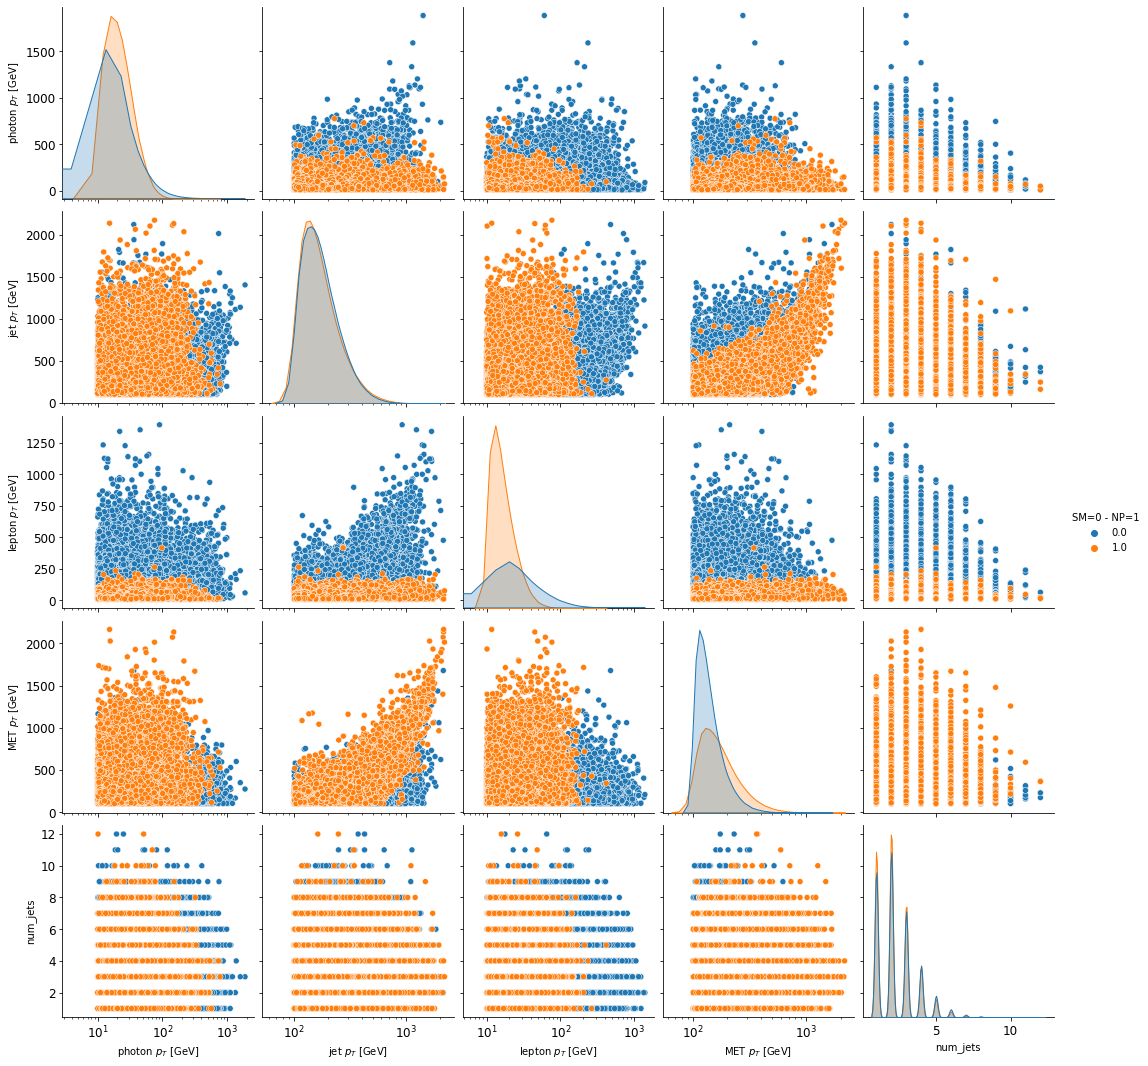

In [150]:
g = sns.pairplot(df, hue="SM=0 - NP=1", height=3,
                 x_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]],
                 y_vars=[lst[0],lst[3],lst[6],lst[9],lst[12]])

log_columns = [lst[0],lst[3],lst[6],lst[9]]

for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

# Analysis

In [85]:
# LOW LEVEL VARIABLES ----------------------
# photon_SM[:,0] : PT
# photon_SM[:,1] : eta
# photon_SM[:,2] : phi

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
# hadinfo_SM[:,0] : hadinfo
# hadinfo_SM[:,1] : number jets
# HT_main_SM : had info total
# MET_sig_SM : MET significace
# m_eff_SM : Effective mass
# mT_photon_SM : transverse mass
print(hadinfo_SM.shape)
print(HT_main_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(150000, 3)
(150000, 3)
(150000, 3)
(150000, 3)
(150000, 2)
(150000,)
(150000,)
(150000,)
(150000,)
(150000,)
(150000,)


In [111]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 9

# LOW LEVEL VARIABLES ----------------------
# photon_NP[bp][:,0] : PT
# photon_NP[bp][:,1] : eta
# photon_NP[bp][:,2] : phi

print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
# hadinfo_NP[bp][:,0] : hadinfo
# hadinfo_NP[bp][:,1] : number jets
# HT_main_NP[bp] : had info total
# MET_sig_NP[bp] : MET significace
# m_eff_NP[bp] : Effective mass
# mT_photon_NP[bp] : transverse mass
print(hadinfo_NP[bp].shape)
print(HT_main_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(326687, 3)
(326687, 3)
(326687, 3)
(326687, 3)
(326687, 2)
(326687,)
(326687,)
(326687,)
(326687,)
(326687,)
(326687,)


In [112]:
nobs = len(photon_SM)

In [113]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ (had) [GeV]', 'num_jets',
       '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= bkg_flag

df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,MET $p_T$ [GeV],...,$m_T$ jet [GeV],$m_T$ lepton [GeV],$\Delta \phi$ (MET-photon),$\Delta \phi$ (MET-jet),$\Delta \phi$ (MET-lepton),$\Delta R$ (photon-jet),$\Delta R$ (photon-lepton),$\Delta R$ (lepton-jet),bkg_flag,SM=0 - NP=1
0,12.30,2.102,-2.640,277.40,0.309,-0.144,62.97,1.864,-3.091,241.73,...,508.208040,23.774707,0.258,2.754,0.193,3.073250,0.509946,3.332092,1.0,0.0
1,19.65,-0.034,2.512,284.92,-0.875,-0.986,151.82,-0.509,1.995,114.55,...,354.243591,72.508431,0.040,3.538,0.557,2.909388,0.702078,3.003384,1.0,0.0
2,14.88,1.119,-1.349,176.83,2.457,-0.259,37.05,0.929,-2.610,163.37,...,338.439394,73.104899,4.044,2.954,5.305,1.725788,1.275234,2.803923,1.0,0.0
3,62.71,-0.144,2.679,157.32,0.248,0.038,22.12,1.172,1.521,142.18,...,89.822819,47.418325,2.031,0.610,0.873,2.669934,1.752946,1.747302,1.0,0.0
4,24.21,1.212,1.649,204.53,0.983,-1.499,86.94,0.914,2.213,118.49,...,310.848302,68.078092,0.120,3.028,0.684,3.143537,0.637887,2.572111,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,79.24,-2.065,-2.547,308.41,-0.440,0.135,36.29,-1.761,2.187,404.45,...,699.171484,153.783525,0.174,2.856,4.908,3.135881,1.578731,2.440440,0.0,1.0
299996,62.48,-0.588,-2.904,125.60,1.117,0.186,23.43,0.061,1.075,160.74,...,281.673589,102.847017,5.966,2.876,1.987,3.529182,2.393840,1.380383,0.0,1.0
299997,17.87,1.447,3.118,176.65,-1.424,2.752,12.91,1.353,1.513,191.89,...,368.197341,81.745713,3.532,3.166,1.927,2.894235,1.607750,3.040863,0.0,1.0
299998,58.88,-0.698,1.433,223.72,-1.415,-0.328,50.41,-1.056,-1.639,216.79,...,438.333325,152.451036,1.577,3.338,4.649,1.901371,3.092790,1.359265,0.0,1.0


In [114]:
nobs = len(df_array)

train_size = int(0.75 * nobs)
test_size  = int(0.2 * nobs)
val_size   = nobs - test_size - train_size

np.random.seed(91218)
random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
test_indices  = random_indices[train_size:(train_size + test_size)]
val_indices   = random_indices[(train_size + test_size):]

In [115]:
X_train        = df_array[train_indices, :25]
bkg_flag_train = df_array[train_indices, 25]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_array[test_indices, :25]
bkg_flag_test = df_array[test_indices, 25]
y_mon_test    = df_array[test_indices, -1]

X_val        = df_array[val_indices, :25]
bkg_flag_val = df_array[val_indices, 25]
y_mon_val    = df_array[val_indices, -1]

In [116]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [117]:
###%%% DEPRECATED
###%%% to normalize
###%%%scaler = preprocessing.MinMaxScaler()
###%%%
###%%%df_norm = scaler.fit_transform(df)
###%%%
###%%%X_mon = df_norm[:,0:25]
###%%%y_mon = df_norm[:,-1]
###%%%
###%%%# divide into train-val and test data samples
###%%%test_ratio = 1./3
###%%%val_ratio = 0.25
###%%%
###%%%X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
###%%%                                                                y_mon,
###%%%                                                                test_size=test_ratio,
###%%%                                                                random_state=42,
###%%%                                                                #stratify = y_mon,
###%%%                                                                shuffle=True)
###%%%
###%%%X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
###%%%                                                                  y_mon_aux,
###%%%                                                                  test_size=val_ratio,
###%%%                                                                  random_state=42,
###%%%                                                                  #stratify = y_mon_aux,
###%%%                                                                  shuffle=True)


print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (225000, 25)
y_mon_train :  (225000,)
X_mon_val :  (15000, 25)
y_mon_val :  (15000,)
X_mon_test :  (60000, 25)
y_mon_test :  (60000,)



In [118]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

[0]	validation_0-logloss:0.64906	validation_1-logloss:0.64883
[1]	validation_0-logloss:0.61249	validation_1-logloss:0.61206
[2]	validation_0-logloss:0.58187	validation_1-logloss:0.58136
[3]	validation_0-logloss:0.55511	validation_1-logloss:0.55454
[4]	validation_0-logloss:0.53241	validation_1-logloss:0.53181
[5]	validation_0-logloss:0.51230	validation_1-logloss:0.51154
[6]	validation_0-logloss:0.49459	validation_1-logloss:0.49379
[7]	validation_0-logloss:0.47902	validation_1-logloss:0.47836
[8]	validation_0-logloss:0.46533	validation_1-logloss:0.46505
[9]	validation_0-logloss:0.45295	validation_1-logloss:0.45272
[10]	validation_0-logloss:0.44232	validation_1-logloss:0.44219
[11]	validation_0-logloss:0.43200	validation_1-logloss:0.43195
[12]	validation_0-logloss:0.42352	validation_1-logloss:0.42359
[13]	validation_0-logloss:0.41557	validation_1-logloss:0.41580
[14]	validation_0-logloss:0.40817	validation_1-logloss:0.40858
[15]	validation_0-logloss:0.40112	validation_1-logloss:0.40173
[1

In [119]:
ind_signal  = np.where(bkg_flag_test == 0)[0]
ind_wgamma  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_test == 3)[0] # tt gamma

In [120]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

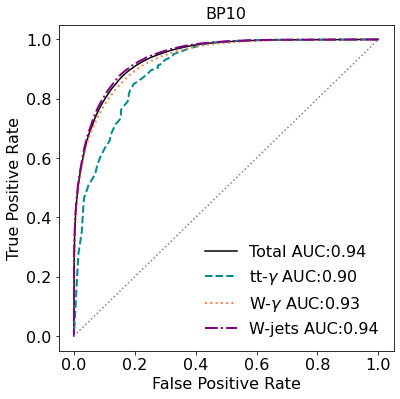

In [121]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = 'darkcyan', linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = 'coral', linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = 'purple', linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '.png', bbox_inches='tight')

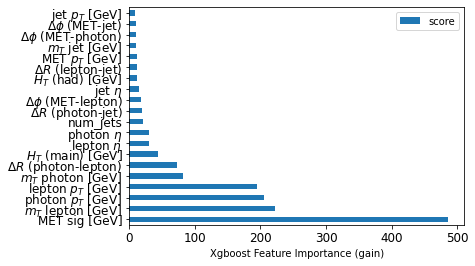

In [122]:
fig, ax = plt.subplots()

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance (gain)")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1][:20]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance.png', bbox_inches='tight')

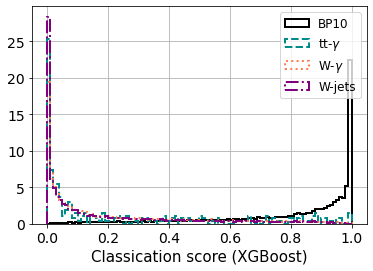

In [123]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'darkcyan', linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'coral', linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'purple', linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '.pdf', bbox_inches="tight")

In [124]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

Text(0.5, 1.0, 'BP10')

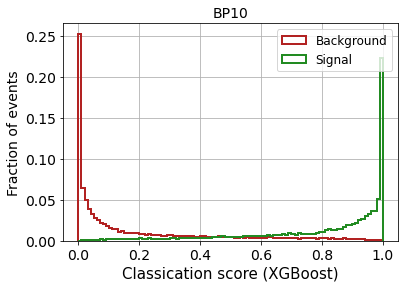

In [125]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)
#plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [126]:
S_expected[bp] / np.sqrt(B_expected)

0.0966094746096924

In [127]:
# Working point
treshold = np.linspace(0.7, 1, 50)

Sexp = []
Bexp = []
for ith, th in enumerate(treshold):
    signalok = len(np.where( y_pred_xg[np.where(bkg_flag_test == 0)[0]] > th)[0])
    backok   = len(np.where( y_pred_xg[np.where(bkg_flag_test != 0)[0]] > th)[0])

    frac_sig = signalok / len(pred_XG_NP)
    frac_bkg = backok / len(pred_XG_SM)

    Sexp.append(S_expected[bp] * frac_sig)
    Bexp.append(B_expected * frac_bkg)

    #print('treshold: ', th)
    #print('Sexp: ', Sexp[ith])
    #print('Bexp: ', Bexp[ith])
    #print('SsqrtB: ', Sexp[ith] / np.sqrt(Bexp[ith]))
    #print('Sig stat full: ', ( 2.* ( (Sexp[ith] + Bexp[ith]) * np.log(1 + (Sexp/[ith]Bexp[ith]) ) - Sexp[ith] ) )**0.5 )
Sexp = np.asarray(Sexp)
Bexp = np.asarray(Bexp)

SsqrtB = Sexp / np.sqrt(Bexp)
Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5 

/tmp/ipykernel_1880811/268401529.py:24: RuntimeWarning: invalid value encountered in true_divide
  SsqrtB = Sexp / np.sqrt(Bexp)
/tmp/ipykernel_1880811/268401529.py:25: RuntimeWarning: invalid value encountered in true_divide
  Sig_full = ( 2.* ( (Sexp + Bexp) * np.log(1 + (Sexp/Bexp) ) - Sexp ) )**0.5


In [128]:
##############
# PARAMETERS #
##############

# requested number of ensembles
n_ensembles = 5000


## LQ up 1400 GeV:
#S_expected = 7 # 6.6095293118432

# ratio S_expected/B_expected (signal ratio)
#SB_ratio = [0.0006, 0.001, 0.0016, 0.0025, 0.005, 0.0075, 0.01, 0.025]

# SOME USEFUL DERIVATED PARAMETERS:

# S/\sqrt{B}
SB_ratio = S_expected[bp]/(1.*B_expected) 
# S/\sqrt{B}
SsqrtB = S_expected[bp]/(B_expected)**0.5

In [129]:
# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]
    
bins = np.linspace(10, 25, 15).astype('int')
Z_bins = np.zeros(len(bins))

for ib, nbin in enumerate(bins):
    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0,1]])
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0,1]])
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

    if np.min(back_prom) > 5:
        # then the signif Z^binned-Asimov:
        Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5

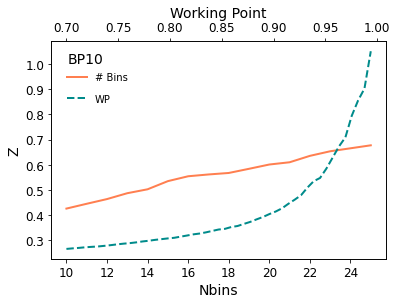

In [130]:
fig,ax = plt.subplots(1,1)

ax2 = ax.twiny()

ax.plot(bins[np.where(Z_bins>0)[0]], Z_bins[np.where(Z_bins>0)[0]], color = 'coral', linewidth =2, label = '# Bins')
ax.set_xlabel('Nbins', fontsize=14)
ax.set_ylabel('Z', fontsize=14)
ax.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.9))

ax2.plot(treshold, Sig_full, color = 'darkcyan', linewidth = 2, ls = '--', label = 'WP')
ax2.set_xlabel('Working Point', fontsize=14)
ax2.legend(frameon = False, loc = 'upper left', bbox_to_anchor = (0.02,0.8))

ax.text(0.05, 0.9, 'BP' + str(bp + 1), fontsize=14, transform = ax.transAxes)

plt.savefig('../graph/Z_WP+Bins_BP' + str(bp + 1) + '.png', bbox_inches='tight')

In [131]:
#################################
# BINNED POISSON LOG-LIKELIHOOD #
#################################

store_Z_bins_XG_16bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []


print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print(r'S/$\sqrt{B}$: ', SsqrtB)

# Les't use an integer number of possible ensembles
N_ensembles_back = len(pred_XG_SM) / B_expected
N_events_back = N_ensembles_back * B_expected

N_ensembles_sig = len(pred_XG_NP) / S_expected[bp]
N_events_sig = N_ensembles_sig * S_expected[bp]



############
# 16 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(16), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(16), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_16bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_16bins.append(Z_bins_16bins)

print('Z_bins_16bins : ', Z_bins_16bins)



############
# 50 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(50), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(50), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_50bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_50bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_50bins.append(Z_bins_50bins)

print('Z_bins_50bins : ', Z_bins_50bins)


############
# 100 bins #
############

#Let's find out the expected number of B and S events in each bin:

# bin the parameter space of all background events
hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(100), range = [[0,1]])
# now divide by the number of possible ensembles
back_prom = hist_back.T.ravel()/N_ensembles_back

# same for signal
hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=(100), range = [[0,1]])
sig_prom = hist_sig.T.ravel()/N_ensembles_sig



# If a bins has no expected background events replace that zero for the minimum B_bin=/=0

# find the minimum
back_prom_noceros = []
for i in range(len(back_prom)):
    if back_prom[i]!=0:
        back_prom_noceros.append(back_prom[i])

min_back = min(back_prom_noceros)

# replace the zeros
for i in range(len(back_prom)):
    if back_prom[i]==0:
        back_prom[i] = min_back

# then the signif Z^binned-Asimov:
Z_bins_100bins = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
#Z_bins_100bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5

store_Z_bins_XG_100bins.append(Z_bins_100bins)

print('Z_bins_100bins : ', Z_bins_100bins)


print('\n ----------------------------------- \n')

B_expected:  171418.81643011243
S_expected:  39.998984577750015
S/$\sqrt{B}$:  0.0966094746096924
Z_bins_16bins :  0.5544602409807257
Z_bins_50bins :  0.8833473424450563
Z_bins_100bins :  0.9851072855305771

 ----------------------------------- 



# Cross-analysis

In [77]:
def train_bp(bp):
    nobs = len(photon_SM)
    
    # Put everything in a single array --------------------------------------------------------
    df = pd.DataFrame()

    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
           'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
           'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
           'MET $p_T$ [GeV]', 'MET $\phi$',
           '$H_T$ (had) [GeV]', 'num_jets',
           '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
           '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
           '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
           '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
           'SM=0 - NP=1']

    df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

    df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
    df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
    df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

    df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
    df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
    df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

    df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
    df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

    df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

    df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
    df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
    df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

    df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
    df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

    df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
    df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
    df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= bkg_flag

    df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    # ---------------------------------------------------------------------------------------------------
    
    # Split train-val ----------------------------------------------------------------------------------
    nobs = len(df_array)
    
    train_size = int(0.75 * nobs)

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_train        = df_array[train_indices, :25]
    bkg_flag_train = df_array[train_indices, 25]
    y_mon_train    = df_array[train_indices, -1]
    
    X_val        = df_array[val_indices, :25]
    bkg_flag_val = df_array[val_indices, 25]
    y_mon_val    = df_array[val_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------------------------------------------------------------------
    scaler = preprocessing.MinMaxScaler()
    scaler = scaler.fit(X_train)

    X_mon_train = scaler.transform(X_train)
    X_mon_val   = scaler.transform(X_val)
    
    classifier = XGBClassifier(
    n_estimators  = 1500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    gamma = 0.0, objective = 'binary:logistic',
    eval_metric = 'logloss', early_stopping_rounds = 50,#early stopping
    max_depth = 5)
    # ---------------------------------------------------------------------------------------------------

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose = 0)
    # ---------------------------------------------------------------------------------------------------

    return classifier, scaler

In [78]:
def pred_bp(bp, classifier, scaler):
    nobs = len(photon_SM)
    
    # Put everything in a single array -------------------------------------------------------------
    df = pd.DataFrame()

    lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$',
           'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
           'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$',
           'MET $p_T$ [GeV]', 'MET $\phi$',
           '$H_T$ (had) [GeV]', 'num_jets',
           '$H_T$ (main) [GeV]', 'MET sig [GeV]', '$m_{eff}$ [GeV]',
           '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
           '$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
           '$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
           'SM=0 - NP=1']

    df[lst[0]]= np.concatenate([photon_SM[:,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[:,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[:,2],photon_NP[bp][:nobs,2]])

    df[lst[3]]= np.concatenate([jet_SM[:,0],jet_NP[bp][:nobs,0]])
    df[lst[4]]= np.concatenate([jet_SM[:,1],jet_NP[bp][:nobs,1]])
    df[lst[5]]= np.concatenate([jet_SM[:,2],jet_NP[bp][:nobs,2]])

    df[lst[6]]= np.concatenate([lepton_SM[:,0],lepton_NP[bp][:nobs,0]])
    df[lst[7]]= np.concatenate([lepton_SM[:,1],lepton_NP[bp][:nobs,1]])
    df[lst[8]]= np.concatenate([lepton_SM[:,2],lepton_NP[bp][:nobs,2]])

    df[lst[9]]= np.concatenate([MET_SM[:,0],MET_NP[bp][:nobs,0]])
    df[lst[10]]= np.concatenate([MET_SM[:,2],MET_NP[bp][:nobs,2]])

    df[lst[11]]= np.concatenate([hadinfo_SM[:,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[12]]= np.concatenate([hadinfo_SM[:,1],hadinfo_NP[bp][:nobs,1]])

    df[lst[13]]= np.concatenate([HT_main_SM,HT_main_NP[bp][:nobs]])
    df[lst[14]]= np.concatenate([MET_sig_SM,MET_sig_NP[bp][:nobs]])
    df[lst[15]]= np.concatenate([m_eff_SM,m_eff_NP[bp][:nobs]])

    df[lst[16]]= np.concatenate([mT_photon_SM,mT_photon_NP[bp][:nobs]])
    df[lst[17]]= np.concatenate([mT_jet_SM,mT_jet_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([mT_lepton_SM,mT_lepton_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([phi_MET_photon_SM,phi_MET_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([phi_MET_jet_SM,phi_MET_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([phi_MET_lepton_SM,phi_MET_lepton_NP[bp][:nobs]])

    df[lst[22]]= np.concatenate([deltaR_photon_jet_SM,deltaR_photon_jet_NP[bp][:nobs]])
    df[lst[23]]= np.concatenate([deltaR_photon_lepton_SM,deltaR_photon_lepton_NP[bp][:nobs]])
    df[lst[24]]= np.concatenate([deltaR_lepton_jet_SM,deltaR_lepton_jet_NP[bp][:nobs]])


    df['bkg_flag']= bkg_flag

    df[lst[25]]= np.concatenate([np.zeros(len(photon_SM)),np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    nobs = len(df_array)
    # ---------------------------------------------------------------------------------------------------

    # Split test --------------------------------------------------------------------------------------
    train_size = int(0.75 * nobs)
    test_size  = int(0.2 * nobs)
    val_size   = nobs - test_size - train_size

    np.random.seed(91218)
    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    test_indices  = random_indices[train_size:(train_size + test_size)]
    val_indices   = random_indices[(train_size + test_size):]
    
    X_test        = df_array[test_indices, :25]
    bkg_flag_test = df_array[test_indices, 25]
    y_mon_test    = df_array[test_indices, -1]
    # ---------------------------------------------------------------------------------------------------

    # Normalize ----------------------------
    X_mon_test  = scaler.transform(X_test)
    # ---------------------------------------------------------------------------------------------------
    
    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]
    # ---------------------------------------------------------------------------------------------------
    
    
    return y_pred_xg, y_mon_test, bkg_flag_test

In [79]:
def roc_curve(y_pred_xg, y_mon_test, bkg_flag_test):
    ind_signal  = np.where(bkg_flag_test == 0)[0]
    ind_wgamma  = np.where(bkg_flag_test == 1)[0] # W gamma
    ind_wjets   = np.where(bkg_flag_test == 2)[0] # W jets
    ind_ttgamma = np.where(bkg_flag_test == 3)[0] # tt gamma
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))
        auc_total = auc(fpr_total, tpr_total)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_wgamma = auc(fpr_wgamma, tpr_wgamma)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
        auc_wjets = auc(fpr_wjets, tpr_wjets)

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
        auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

    return tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma,tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma

In [82]:
def bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected):
    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    #B_expected = (1674.4584461333332 + 59997.68515734306 + 64899.72420521739) 
    # Les't use an integer number of possible ensembles
    N_ensembles_back = len(pred_XG_SM) / B_expected
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = len(pred_XG_NP) / S_expected
    N_events_sig = N_ensembles_sig * S_expected

    bins = np.linspace(10, 25, 15).astype('int')
    Z_bins = np.zeros(len(bins))

    for ib, nbin in enumerate(bins):
        # bin the parameter space of all background events
        hist_back, binedges_back = np.histogramdd([pred_XG_SM], bins=(nbin), range = [[0,1]])
        # now divide by the number of possible ensembles
        back_prom = hist_back.T.ravel()/N_ensembles_back

        # same for signal
        hist_sig, binedges_sig = np.histogramdd([pred_XG_NP], bins=binedges_back, range = [[0,1]])
        sig_prom = hist_sig.T.ravel()/N_ensembles_sig        

        if np.min(back_prom) > 5:
            # then the signif Z^binned-Asimov:
            Z_bins[ib] = ( 2* sum( ( (back_prom + sig_prom) * np.log( 1 + (sig_prom / back_prom) ) ) - sig_prom ) )**0.5
    return bins, Z_bins

0
1
2
3
4


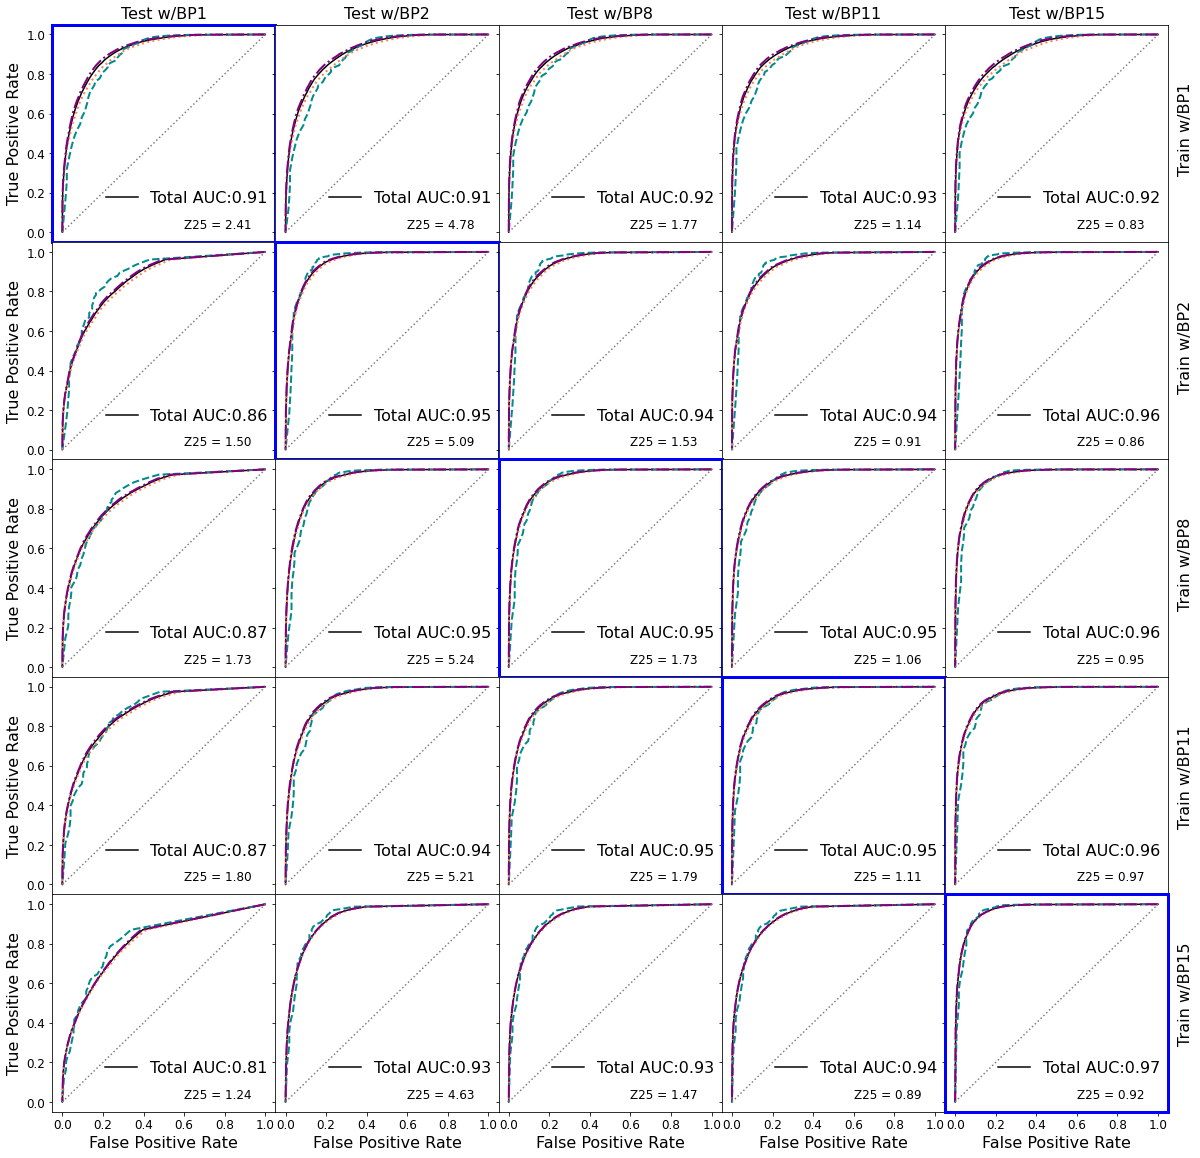

In [83]:
bps = [0,1,7,10,14]
fig,ax = plt.subplots(len(bps),len(bps), figsize = (20,20), sharex = True, sharey = True)

plt.subplots_adjust(wspace = 0, hspace = 0)

for i, bptrain in enumerate(bps):
    print(i)
    for j, bptest in enumerate(bps):
        classifier, scaler = train_bp(bptrain)
        y_pred_xg, y_mon_test, bkg_flag_test = pred_bp(bptest, classifier, scaler)
        tpr_total, fpr_total, auc_total, tpr_wgamma, fpr_wgamma, auc_wgamma, tpr_wjets, fpr_wjets, auc_wjets, tpr_ttgamma, fpr_ttgamma, auc_ttgamma = roc_curve(y_pred_xg, y_mon_test, bkg_flag_test)
        bins, Z_bins = bin_lik_bp(y_pred_xg, bkg_flag_test, S_expected[bptest])
                
        ax[i,j].plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
        ax[i,j].plot(fpr_ttgamma, tpr_ttgamma, c = 'darkcyan', linestyle = '--', lw = 2)
        ax[i,j].plot(fpr_wgamma, tpr_wgamma, c = 'coral', linestyle = ':', lw = 2)
        ax[i,j].plot(fpr_wjets, tpr_wjets, c = 'purple', linestyle = '-.', lw = 2)
        ax[i,j].legend(frameon=False, fontsize=16, loc = 'lower right', bbox_to_anchor = (1.03,0.1))
        ax[i,j].text(0.6,0.02, 'Z{} = {:.2f}'.format(bins[np.argmax(Z_bins)], np.max(Z_bins)), fontsize = 12)
        ax[i,j].plot([0,1],[0,1],ls=":",color="grey")
#ax[i,j].title(r"BP" + str(bp + 1),fontsize=16)
        if i == 0: ax[i,j].set_title("Test w/BP" + str(bptest + 1), fontsize=16)
        if j == 0: ax[i,j].set_ylabel("True Positive Rate", fontsize=16)
        if j == (len(bps) - 1): ax[i,j].text(1.1,0.3,"Train w/BP" + str(bptrain + 1),rotation = 90,fontsize=16)
        if j == i: 
            ax[i,j].spines['top'].set_color('blue')  # Top spine
            ax[i,j].spines['bottom'].set_color('blue')  # Bottom spine
            ax[i,j].spines['left'].set_color('blue')  # Left spine
            ax[i,j].spines['right'].set_color('blue')  # Right spine
            ax[i,j].spines['top'].set_linewidth(3)
            ax[i,j].spines['bottom'].set_linewidth(3)
            ax[i,j].spines['left'].set_linewidth(3)
            ax[i,j].spines['right'].set_linewidth(3)        
        if i == (len(bps) - 1): ax[i,j].set_xlabel("False Positive Rate",fontsize=16)

plt.savefig('../graph/cross_analysis_1-2-8-11-15.png')